# Load dataset

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [1]:
df = pd.DataFrame()
for decade in ['60', '70', '80', '90', '00', '10']:
    url = f'https://raw.githubusercontent.com/fortyTwo102/The-Spotify-Hit-Predictor-Dataset/master/dataset-of-{decade}s.csv'
    new_data = pd.read_csv(url)
    new_data['decade'] = int(decade)
    new_data['is_hit'] = new_data['target']
    new_data = new_data.drop(columns=['target'])
    df = df.append(new_data)

df.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,decade,is_hit
0,Jealous Kind Of Fella,Garland Green,spotify:track:1dtKN6wwlolkM8XZy2y9C1,0.417,0.620,3,-7.727,1,0.0403,0.490,0.000000,0.0779,0.845,185.655,173533,3,32.94975,9,60,1
1,Initials B.B.,Serge Gainsbourg,spotify:track:5hjsmSnUefdUqzsDogisiX,0.498,0.505,3,-12.475,1,0.0337,0.018,0.107000,0.1760,0.797,101.801,213613,4,48.82510,10,60,0
2,Melody Twist,Lord Melody,spotify:track:6uk8tI6pwxxdVTNlNOJeJh,0.657,0.649,5,-13.392,1,0.0380,0.846,0.000004,0.1190,0.908,115.940,223960,4,37.22663,12,60,0
3,Mi Bomba Sonó,Celia Cruz,spotify:track:7aNjMJ05FvUXACPWZ7yJmv,0.590,0.545,7,-12.058,0,0.1040,0.706,0.024600,0.0610,0.967,105.592,157907,4,24.75484,8,60,0
4,Uravu Solla,P. Susheela,spotify:track:1rQ0clvgkzWr001POOPJWx,0.515,0.765,11,-3.515,0,0.1240,0.857,0.000872,0.2130,0.906,114.617,245600,4,21.79874,14,60,0


In [2]:
df.shape

(41106, 20)

# Supporting functions

In [130]:
''' print metrics and confusion matrix '''
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix

def get_metrics(test_y, preds):
    print("Accuracy: ", accuracy_score(test_y, preds))
    print("Precision: ", precision_score(test_y, preds))
    print("Recall: ", recall_score(test_y, preds))
    print("F1: ", f1_score(test_y, preds))

def get_cm(test_y, preds):
    cm=confusion_matrix(test_y, preds)
    sns.heatmap(cm,cmap='BuPu',annot=True,fmt='d', xticklabels=['not a hit', 'hit'], yticklabels=['not a hit', 'hit'])

In [131]:
# train test split 
from sklearn.model_selection import train_test_split

X = df[['danceability', 'energy', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
            'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit',
            'sections', 'decade']]
y = df.iloc[:, -1]

train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2,random_state=45,stratify=y)

In [133]:
'''mean and std for cv folds'''

def cv_results(grid_search): 
    cv_results = grid_search.cv_results_

    mean_test_score = cv_results['mean_test_score'][grid_search.best_index_]
    std_test_score = cv_results['std_test_score'][grid_search.best_index_]

    print("mean test score:", mean_test_score)
    print("std test score:", std_test_score)


# Baseline - Logistic Regression 

### From proposal


In [223]:
from sklearn.linear_model import LogisticRegression

In [224]:
lr_clf = LogisticRegression()
lr_clf.fit(train_X, train_y)

# Make predictions on the test data
lr_preds = lr_clf.predict(test_X)

Accuracy:  0.5143517392361956
Precision:  0.5137914913510987
Recall:  0.5346630990026757
F1:  0.5240195494099417


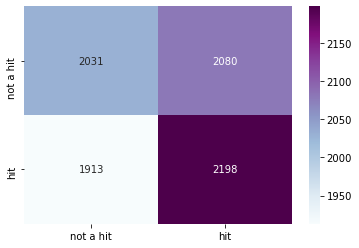

In [225]:
get_metrics(test_y, lr_preds)
get_cm(test_y, lr_preds)

# Logistic Regression with L1 (lasso) Regularization - l2 ridge is default

In [226]:
l1_lr_clf = LogisticRegression(penalty='l1', solver='liblinear')
l1_lr_clf.fit(train_X, train_y)

# Make predictions on the test data
lr_l1_preds = l1_lr_clf.predict(test_X)

Accuracy:  0.7209924592556556
Precision:  0.6882901554404145
Recall:  0.8078326441255169
F1:  0.7432855863921217


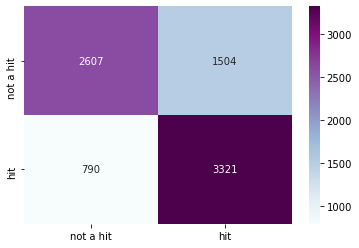

In [227]:
get_metrics(test_y, lr_l1_preds)
get_cm(test_y, lr_l1_preds)

Try scaling data - log reg usually needs scaling

In [228]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
scaler = StandardScaler()  
scaler.fit(train_X)  

scaled_train_X = scaler.transform(train_X)  
scaled_test_X = scaler.transform(test_X)  

param_grid = {
    'C': np.logspace(-4, 4, 20)
}

lr_l1_clf = LogisticRegression(penalty='l1', solver='liblinear')

lr_grid_search = GridSearchCV(lr_l1_clf, param_grid, cv=5, scoring='accuracy')
lr_grid_search.fit(scaled_train_X, train_y)

lr_l1_preds = lr_grid_search.predict(scaled_test_X)

lr_grid_search.best_params_

{'C': 29.763514416313132}

In [229]:
cv_results(lr_grid_search)

mean test score: 0.7228136732852486
std test score: 0.0061710902799025835


Accuracy:  0.7206275845293116
Precision:  0.6882523868825239
Recall:  0.8066163950377038
F1:  0.7427483480792922


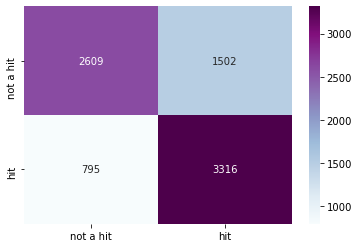

In [230]:
lr_grid_search.fit(scaled_train_X, train_y)

# Make predictions on the test data
lr_l1_preds = lr_grid_search.predict(scaled_test_X)

get_metrics(test_y, lr_l1_preds)
get_cm(test_y, lr_l1_preds)

Essentially the same as the empty lasso LR model

Beats the baseline logistic regression

# Naive Bayes

In [142]:
from sklearn.naive_bayes import GaussianNB

Accuracy:  0.5919484310386767
Precision:  0.5556537102473498
Recall:  0.9180248114813914
F1:  0.692286526644043


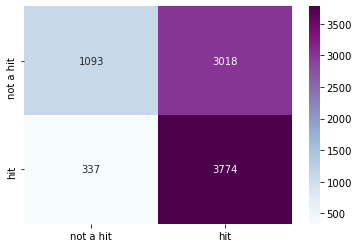

In [143]:
# empty model
nb_clf = GaussianNB()
nb_clf.fit(train_X, train_y)
nb_preds = nb_clf.predict(test_X)

get_metrics(test_y, nb_preds)
get_cm(test_y, nb_preds)

In [144]:
# parameter tuning
import numpy as np 

param_grid = {'var_smoothing': np.logspace(0,-9, num=100)} #https://www.kaggle.com/code/akshaysharma001/naive-bayes-with-hyperpameter-tuning#kln-196

# try scaling 
scaler = StandardScaler()  
scaler.fit(train_X)  

scaled_train_X = scaler.transform(train_X)  
scaled_test_X = scaler.transform(test_X)  

nb_clf = GaussianNB()

nb_grid_search = GridSearchCV(nb_clf, param_grid, cv=5, scoring='accuracy')
nb_grid_search.fit(scaled_train_X, train_y)

nb_preds = nb_grid_search.predict(scaled_test_X)

nb_grid_search.best_params_

{'var_smoothing': 2.310129700083158e-05}

In [145]:
cv_results(nb_grid_search)

mean test score: 0.7100413934203357
std test score: 0.0035550231015557534


Accuracy:  0.7051812211140842
Precision:  0.6559437973747458
Recall:  0.8630503527122355
F1:  0.7453781512605043


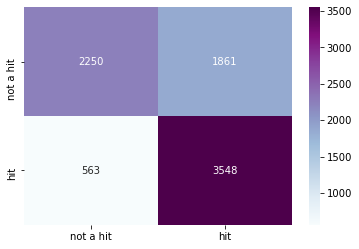

In [146]:
get_metrics(test_y, nb_preds)
get_cm(test_y, nb_preds)

in some metrics it is better (marginally)

# Decision Tree

In [147]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

Accuracy:  0.7135733398199952
Precision:  0.7145650048875856
Recall:  0.7112624665531501
F1:  0.7129099110081677


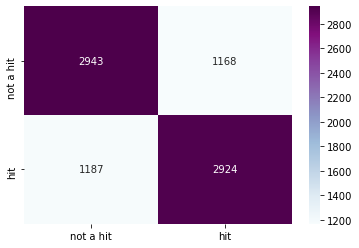

In [148]:
# empty model 
tree_clf = DecisionTreeClassifier()
tree_clf.fit(train_X, train_y)
tree_preds = tree_clf.predict(test_X)

get_metrics(test_y, tree_preds)
get_cm(test_y, tree_preds)

for computation sake, only test out a few params in the reasonable range of values

In [149]:
# parameter tuning
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [3, 5, 10, 20],
    'min_samples_leaf': [1, 2, 6 ],  # overfit with >10,
    'min_samples_split': [2, 4, 6] # overfit with >10,
}


tree_clf = DecisionTreeClassifier()

# perform the grid search using 5-fold cross validation
tree_grid_search = GridSearchCV(tree_clf, param_grid, cv=5, scoring='accuracy')
tree_grid_search.fit(X, y)

tree_preds = tree_grid_search.predict(test_X)

tree_grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 6,
 'min_samples_split': 2}

In [150]:
cv_results(tree_grid_search)

mean test score: 0.7387742102880323
std test score: 0.03951958374222001


Accuracy:  0.8021162734127949
Precision:  0.7495980707395499
Recall:  0.9073218195086353
F1:  0.8209530097942115


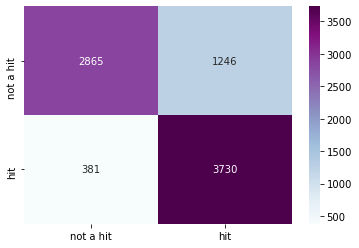

In [151]:
get_metrics(test_y, tree_preds)
get_cm(test_y, tree_preds)

New best 

# Random Forest 

In [152]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

Accuracy:  0.7926295305278521
Precision:  0.7639315489249671
Recall:  0.8469958647531014
F1:  0.8033221824893299


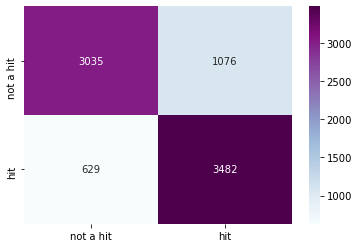

In [153]:
# empty model
rf_clf = RandomForestClassifier()
rf_clf.fit(train_X, train_y)
rf_preds = rf_clf.predict(test_X)

get_metrics(test_y, rf_preds)
get_cm(test_y, rf_preds)

In [154]:
# parameter tuning

# use same grid as for decision tree 
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [3, 5, 10, 20],
    'min_samples_leaf': [1, 2, 6 ],  # overfit with >10,
    'min_samples_split': [2, 4, 6] # overfit with >10,
}


rf_clf = RandomForestClassifier()

# perform the grid search using 5-fold cross validation
rf_grid_search = GridSearchCV(rf_clf, param_grid, cv=5, scoring='accuracy')
rf_grid_search.fit(X, y)

rf_preds = rf_grid_search.predict(test_X)

rf_grid_search.best_params_

{'criterion': 'log_loss',
 'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [155]:
cv_results(rf_grid_search)

mean test score: 0.7712518364680683
std test score: 0.04902046208296997


Accuracy:  0.9549987837509122
Precision:  0.9174291452800715
Recall:  1.0
F1:  0.9569366852886407


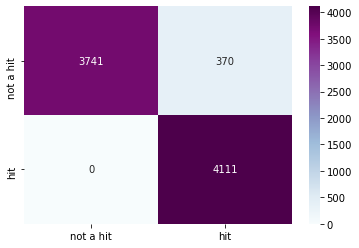

In [157]:
get_metrics(test_y, rf_preds)
get_cm(test_y, rf_preds)

by far the best performing model

# Neural Network

for testing out diff settings, params, num layers, optimizer, etc we just used trial and error, no algorithmic approach

# Pytorch

Followed this tutorial: https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89

Was clearer than the pytorch tutorial offered in class

In [204]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    

In [205]:
# scale data 
scaler = StandardScaler()
X_train = scaler.fit_transform(train_X)
X_test = scaler.transform(test_X)

# settings 
BATCH_SIZE = 64

In [206]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

In [207]:
train_data = TrainData(torch.Tensor(X_train), torch.Tensor(train_y.to_numpy()))
test_data = TestData(torch.FloatTensor(X_test))

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [208]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

## build model structure

start with testing out diff num of layers and neuron sizes then fix the model arch to do cv on other parameters

In [209]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        
        # Number of input features is 14.
        self.layer_1 = nn.Linear(14, 10) 
        self.layer_2 = nn.Linear(10, 10)
        self.layer_3 = nn.Linear(10, 30)
        self.layer_4 = nn.Linear(30, 60)
        self.layer_5 = nn.Linear(60, 60)
        self.layer_6 = nn.Linear(60, 60)
        self.layer_out = nn.Linear(60, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.relu(self.layer_4(x))
        x = self.relu(self.layer_5(x))
        x = self.relu(self.layer_6(x))
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x


In [212]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LEARNING_RATE = 0.001

model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)


BinaryClassification(
  (layer_1): Linear(in_features=14, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=30, bias=True)
  (layer_4): Linear(in_features=30, out_features=60, bias=True)
  (layer_5): Linear(in_features=60, out_features=60, bias=True)
  (layer_6): Linear(in_features=60, out_features=60, bias=True)
  (layer_out): Linear(in_features=60, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)


In [213]:
EPOCHS = 50 

model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

nn_preds = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        nn_preds.append(y_pred_tag.cpu().numpy())

nn_preds = [a.squeeze().tolist() for a in nn_preds]

Epoch 001: | Loss: 0.69401 | Acc: 49.981
Epoch 002: | Loss: 0.69370 | Acc: 50.004
Epoch 003: | Loss: 0.69357 | Acc: 50.010
Epoch 004: | Loss: 0.69344 | Acc: 49.992
Epoch 005: | Loss: 0.69338 | Acc: 49.998
Epoch 006: | Loss: 0.69330 | Acc: 49.988
Epoch 007: | Loss: 0.69326 | Acc: 49.973
Epoch 008: | Loss: 0.69322 | Acc: 50.053
Epoch 009: | Loss: 0.69318 | Acc: 50.148
Epoch 010: | Loss: 0.69322 | Acc: 49.558
Epoch 011: | Loss: 0.69322 | Acc: 49.539
Epoch 012: | Loss: 0.69320 | Acc: 49.897
Epoch 013: | Loss: 0.69313 | Acc: 49.874
Epoch 014: | Loss: 0.69319 | Acc: 49.702
Epoch 015: | Loss: 0.69313 | Acc: 50.815
Epoch 016: | Loss: 0.69317 | Acc: 49.977
Epoch 017: | Loss: 0.69316 | Acc: 49.942
Epoch 018: | Loss: 0.69313 | Acc: 50.874
Epoch 019: | Loss: 0.69316 | Acc: 50.831
Epoch 020: | Loss: 0.69314 | Acc: 49.982
Epoch 021: | Loss: 0.69315 | Acc: 49.860
Epoch 022: | Loss: 0.69312 | Acc: 50.307
Epoch 023: | Loss: 0.69313 | Acc: 50.574
Epoch 024: | Loss: 0.69309 | Acc: 50.685
Epoch 025: | Los

Accuracy:  0.55996108002919
Precision:  0.5429218178652272
Recall:  0.7584529311603017
F1:  0.6328394560584535


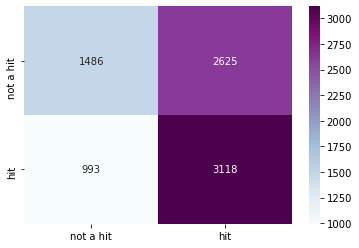

In [214]:
get_metrics(test_y, nn_preds)
get_cm(test_y, nn_preds)

## CV w fixed model arch

In [215]:
# model class 
class BinaryClassification(nn.Module):
    def __init__(self, learning_rate, optimizer, weight_decay):
        super(BinaryClassification, self).__init__()
        
        # Number of input features is 14.
        self.layer_1 = nn.Linear(14, 10) 
        self.layer_2 = nn.Linear(10, 10)
        self.layer_3 = nn.Linear(10, 30)
        self.layer_4 = nn.Linear(30, 60)
        self.layer_5 = nn.Linear(60, 60)
        self.layer_6 = nn.Linear(60, 60)
        self.layer_out = nn.Linear(60, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)

        # set params 
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.weight_decay = weight_decay
        
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.relu(self.layer_4(x))
        x = self.relu(self.layer_5(x))
        x = self.relu(self.layer_6(x))
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

    # fit, predict and score functions for gridsearchcv
    def fit(self, X, y):
        train_data = TrainData(torch.Tensor(X), torch.Tensor(y.values.ravel()))
        train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(device)
        
        criterion = nn.BCEWithLogitsLoss()
        optimizer = self.optimizer(self.parameters(), lr=self.learning_rate, weight_decay = self.weight_decay)

        EPOCHS = 50

        self.train()
        for e in range(1, EPOCHS+1):
            epoch_loss = 0
            epoch_acc = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                
                y_pred = self(X_batch)
                
                loss = criterion(y_pred, y_batch.unsqueeze(1))
                acc = binary_acc(y_pred, y_batch.unsqueeze(1))
                
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                epoch_acc += acc.item()

    def predict(self, X):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        test_data = TestData(torch.FloatTensor(X_test))
        test_loader = DataLoader(dataset=test_data, batch_size=1)
        
        nn_preds = []
        self.eval()
        with torch.no_grad():
            for X_batch in test_loader:
                X_batch = X_batch.to(device)
                y_test_pred = self(X_batch)
                y_test_pred = torch.sigmoid(y_test_pred)
                y_pred_tag = torch.round(y_test_pred)
                nn_preds.append(y_pred_tag.cpu().numpy())

        nn_preds = [a.squeeze().tolist() for a in nn_preds]
        # nn_preds = torch.tensor(nn_preds)  
        return nn_preds



    def score(self, X, y):
        y_pred = self.predict(X_test)
        return accuracy_score(test_y, y_pred)

    # get and set params like in scikit
    def get_params(self, deep = True):
        return {
            'learning_rate': self.learning_rate,
            'optimizer': self.optimizer,
            'weight_decay': self.weight_decay
        }
    
    def set_params(self, **params):
        self.learning_rate = params['learning_rate']
        self.optimizer = params['optimizer']
        self.weight_decay = params['weight_decay']
        return self
        

In [216]:
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'optimizer': [optim.SGD, optim.Adam],
    'weight_decay': [0.0, 0.01] # regularization strength 
}

model = BinaryClassification(learning_rate=0.01, optimizer=optim.SGD, weight_decay=0.0) # initialize w defaults
nn_grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
nn_grid_search.fit(X_train, train_y)

nn_preds = nn_grid_search.predict(X_test)

nn_grid_search.best_params_

{'learning_rate': 0.001,
 'optimizer': torch.optim.adam.Adam,
 'weight_decay': 0.0}

In [219]:
cv_results(nn_grid_search)

mean test score: 0.7880077839941619
std test score: 0.0019184377672712518


Accuracy:  0.788007783994162
Precision:  0.7557235421166306
Recall:  0.8511311116516662
F1:  0.8005948976089692


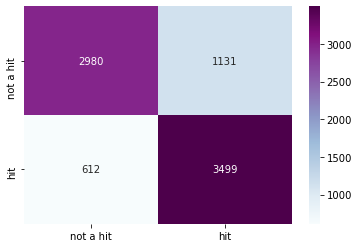

In [220]:
get_metrics(test_y, nn_preds)
get_cm(test_y, nn_preds)

# Results

In [231]:
results = pd.DataFrame()

model_preds = {'Logistic Regression - Baseline' : lr_preds
            , 'Lasso Logistic Regression' : lr_l1_preds
            , 'Naive Bayes': nb_preds
            , 'Decision Tree': tree_preds
            , 'Random Forest': rf_preds
            , 'Neural Net': nn_preds}

for model in model_preds.keys():

    preds = model_preds[model]

    results = results.append({'Model':model
                , 'Accuracy': accuracy_score(test_y, preds)
                , 'Precision': precision_score(test_y, preds)
                , 'Recall': recall_score(test_y, preds)
                , 'F1': f1_score(test_y, preds)}
                , ignore_index=True)

results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1']]

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression - Baseline,0.514352,0.513791,0.534663,0.524020
1,Lasso Logistic Regression,0.720628,0.688252,0.806616,0.742748
2,Naive Bayes,0.705181,0.655944,0.863050,0.745378
3,Decision Tree,0.802116,0.749598,0.907322,0.820953
4,Random Forest,0.954999,0.917429,1.000000,0.956937
5,Neural Net,0.788008,0.755724,0.851131,0.800595


Determine best by accuracy since data is balanced 

In [232]:
results[['Model', 'Precision', 'Recall', 'F1', 'Accuracy']].sort_values(by=['Accuracy'], ascending=False)

,Model,Precision,Recall,F1,Accuracy
4,Random Forest,0.917429,1.000000,0.956937,0.954999
3,Decision Tree,0.749598,0.907322,0.820953,0.802116
5,Neural Net,0.755724,0.851131,0.800595,0.788008
1,Lasso Logistic Regression,0.688252,0.806616,0.742748,0.720628
2,Naive Bayes,0.655944,0.863050,0.745378,0.705181
0,Logistic Regression - Baseline,0.513791,0.534663,0.524020,0.514352


interestingly both f1 and accuracy are ordered the same 